<a href="https://colab.research.google.com/github/Zabihuddin/data_analysis/blob/main/deepfake_detection_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
# Connect to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step - accuracy: 0.6421 - loss: 0.6771 - val_accuracy: 0.7398 - val_loss: 0.5275
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.7676 - loss: 0.5291 - val_accuracy: 0.8049 - val_loss: 0.4726
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.8281 - loss: 0.3872 - val_accuracy: 0.8537 - val_loss: 0.4003
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 66s 4s/step - accuracy: 0.8711 - loss: 0.3704 - val_accuracy: 0.8293 - val_loss: 0.4240
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.8678 - loss: 0.3048 - val_accuracy: 0.8211 - val_loss: 0.4220
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.8377 - loss: 0.3545 - val_accuracy: 0.7967 - val_loss: 0.4545
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.8654 - loss: 0.3331 - val_accuracy: 0.8211 - val_loss: 0.4079
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.9099 - loss: 0.2590 - val_accuracy: 0.7805 - val_loss: 0.4501
Epo

Model saved as 'advanced_deepfake_detection_model.h5'


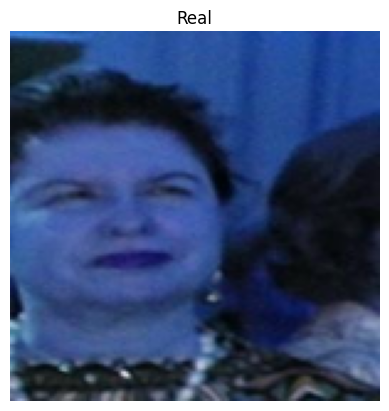

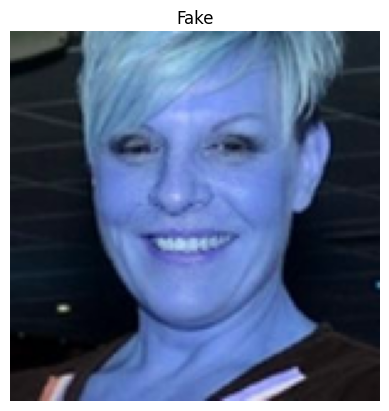

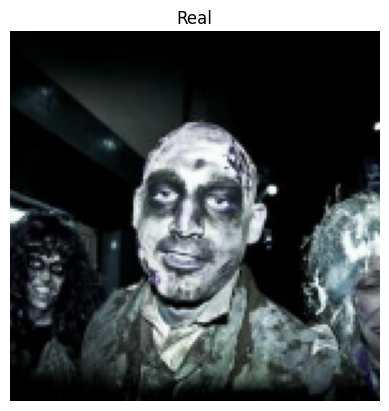

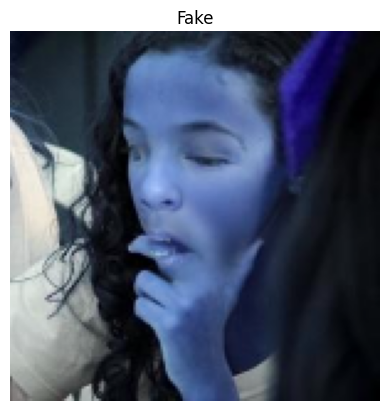

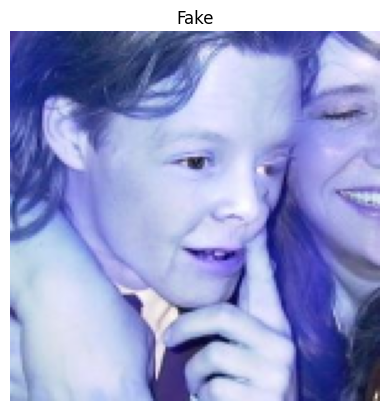

3/4 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.66      0.78        68
         1.0       0.70      0.96      0.81        55

    accuracy                           0.80       123
   macro avg       0.83      0.81      0.80       123
weighted avg       0.84      0.80      0.79       123

ROC-AUC Score: 0.9360962566844919


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Directories for datasets
fake_dir = "/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/Fake"
real_dir = "/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/Real"

# Parameters
img_size = 150
batch_size = 32
epochs = 10

# Function to load and preprocess images
def load_images_from_directory(directory, label):
    images, labels = [], []
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        if file.endswith(('.jpeg', '.jpg', '.png')):
            img = cv2.imread(file_path)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                images.append(img)
                labels.append(label)
    return np.array(images, dtype="float32"), np.array(labels, dtype="float32")

# Load datasets
fake_images, fake_labels = load_images_from_directory(fake_dir, label=0)
real_images, real_labels = load_images_from_directory(real_dir, label=1)

# Combine datasets
X = np.concatenate((fake_images, real_images), axis=0)
y = np.concatenate((fake_labels, real_labels), axis=0)

# Normalize images
X = X / 255.0

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation
data_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
data_gen.fit(X_train)

# Load pre-trained Xception model
base_model = Xception(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    data_gen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    epochs=epochs
)

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Fine-tune the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
history_fine = model.fit(
    data_gen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    epochs=5
)

# Save the model
model.save("advanced_deepfake_detection_model.h5")
print("Model saved as 'advanced_deepfake_detection_model.h5'")

# Display a few training images
for i in range(5):
    plt.imshow(X_train[i])
    label = "Real" if y_train[i] == 1 else "Fake"
    plt.title(label)
    plt.axis('off')
    plt.show()

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))



In [ ]:
def predict_and_visualize(image_path, model, layer_name='block14_sepconv2_act'):
    """
    Predict and visualize Grad-CAM for a new image.
    Args:
        image_path: Path to the new image.
        model: The trained model.
        layer_name: The name of the layer for Grad-CAM visualization.
    """
    try:
        # Load and preprocess the image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Image not found or unreadable: {image_path}")

        # Resize and normalize the input image
        img_resized = cv2.resize(img, (img_size, img_size))
        img_input = np.expand_dims(img_resized / 255.0, axis=0)

        # Predict real or fake
        prediction = model.predict(img_input)[0][0]
        label = "Real" if prediction > 0.5 else "Fake"
        confidence = prediction if label == "Real" else 1 - prediction

        print(f"Prediction: {label} (Confidence: {confidence:.2f})")

        # Grad-CAM visualization
        grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_input)
            loss = predictions[:, 0]

        grads = tape.gradient(loss, conv_outputs)[0]
        weights = tf.reduce_mean(grads, axis=(0, 1))
        cam = np.sum(weights * conv_outputs[0], axis=-1)
        cam = np.maximum(cam, 0)

        # Resize and normalize the CAM
        cam = cv2.resize(cam, (img_size, img_size))
        cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize to [0, 1]

        # Generate heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

        # Convert the original image to uint8
        img_resized_uint8 = np.uint8(img_resized)

        # Superimpose the heatmap on the original image
        superimposed = cv2.addWeighted(img_resized_uint8, 0.6, heatmap, 0.4, 0)

        # Display results
        plt.figure(figsize=(12, 6))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')

        # Grad-CAM Visualization
        plt.subplot(1, 3, 2)
        plt.imshow(superimposed[..., ::-1])  # Convert BGR to RGB
        plt.title("Grad-CAM Visualization")
        plt.axis('off')

        # Combined Label and Confidence
        plt.subplot(1, 3, 3)
        plt.text(0.5, 0.5, f"Prediction:\n{label}\nConfidence: {confidence:.2f}",
                 fontsize=12, ha='center', va='center', wrap=True)
        plt.gca().set_facecolor('white')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error: {e}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Prediction: Real (Confidence: 0.93)


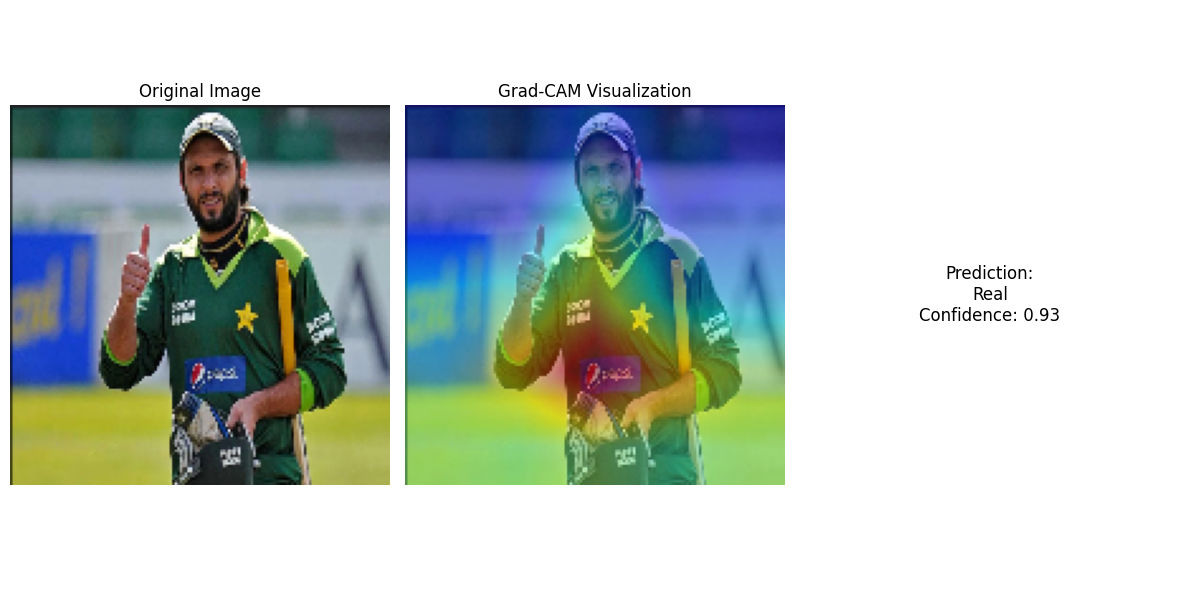

In [ ]:
# Example usage
demo_image_path = "/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/newdata/shaidafridi.png"  # Replace with your image path
predict_and_visualize(demo_image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Prediction: Fake (Confidence: 0.74)


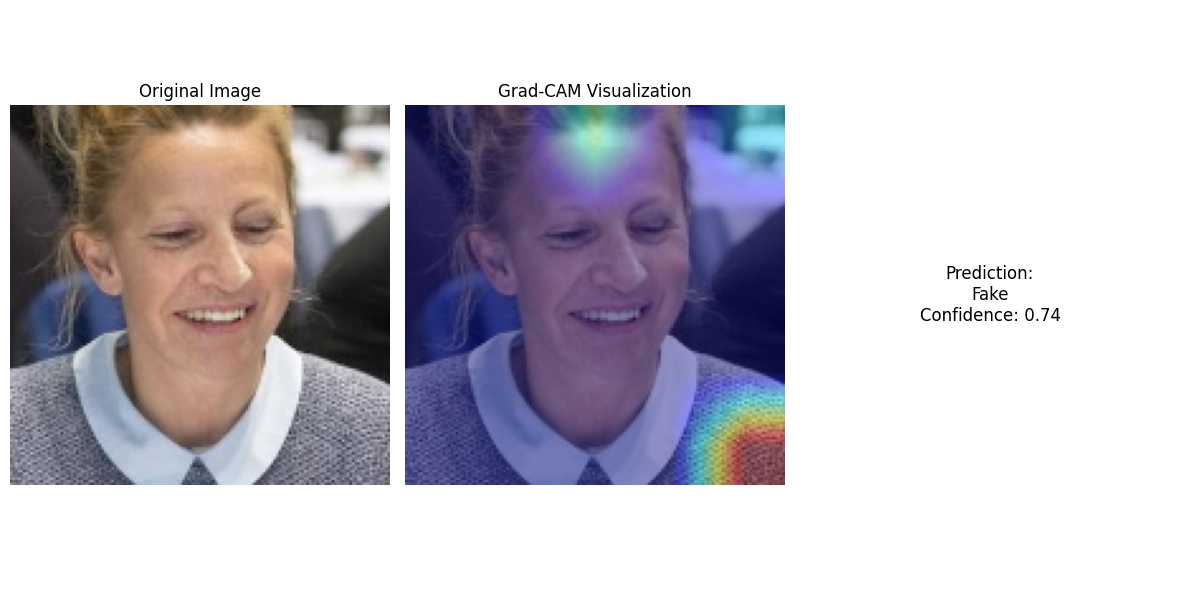

In [ ]:
# Example usage
demo_image_path = "/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/Fake/fake_9678.jpg"  # Replace with your image path
predict_and_visualize(demo_image_path, model)


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step


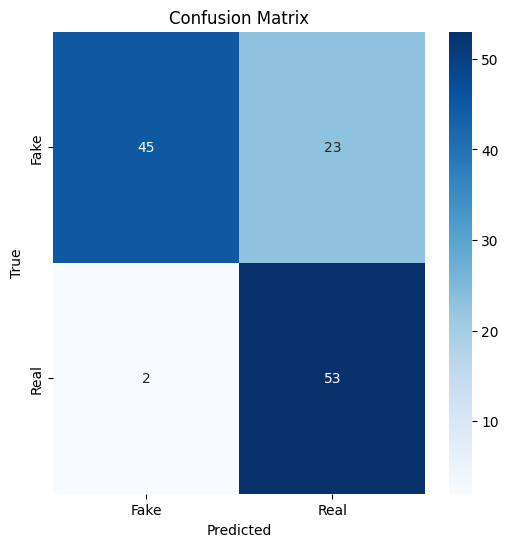

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes=["Fake", "Real"]):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Generate predictions
y_pred_probs = model.predict(X_test).flatten()  # Flatten to 1D array
y_pred = (y_pred_probs > 0.5).astype(int)       # Convert probabilities to binary predictions

# Confusion Matrix
plot_confusion_matrix(y_test, y_pred)





4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step


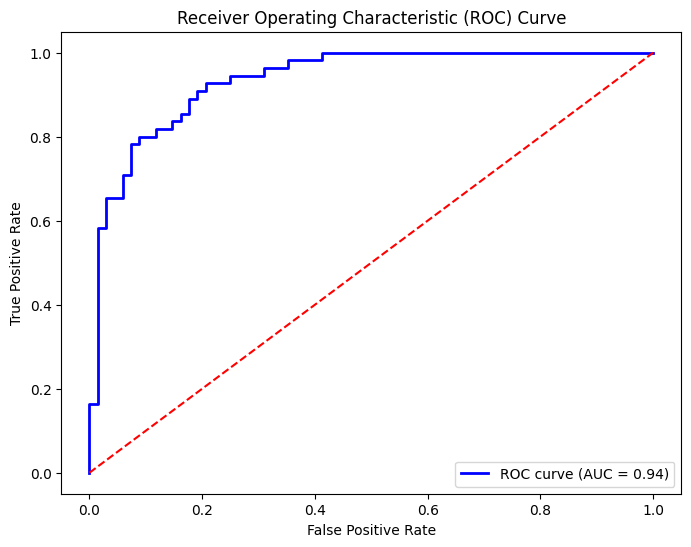

In [ ]:
def plot_roc_curve(y_true, y_probs):
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="red", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

y_pred_probs = model.predict(X_test).flatten()  # Flatten to 1D array
y_pred = (y_pred_probs > 0.5).astype(int)       # Convert probabilities to binary predictions

    # ROC Curve
plot_roc_curve(y_test, y_pred_probs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step


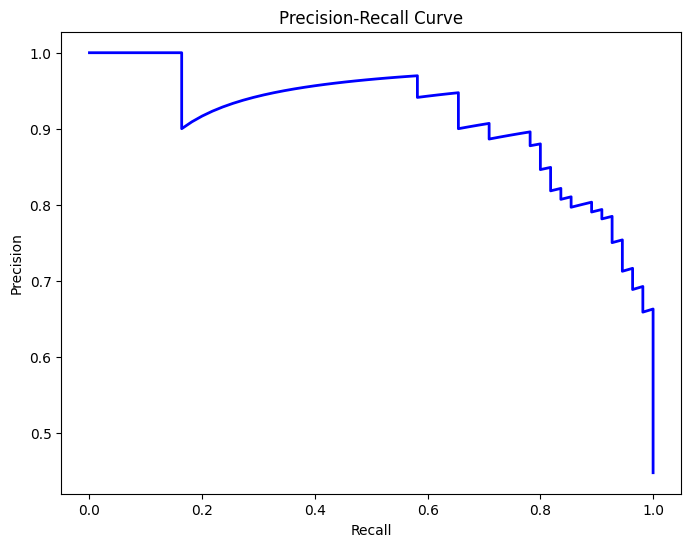

In [ ]:
def plot_precision_recall_curve(y_true, y_probs):
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color="blue", lw=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.show()
    # Generate predictions
y_pred_probs = model.predict(X_test).flatten()  # Flatten to 1D array
y_pred = (y_pred_probs > 0.5).astype(int)       # Convert probabilities to binary predictions



# Precision-Recall Curve
plot_precision_recall_curve(y_test, y_pred_probs)



4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step


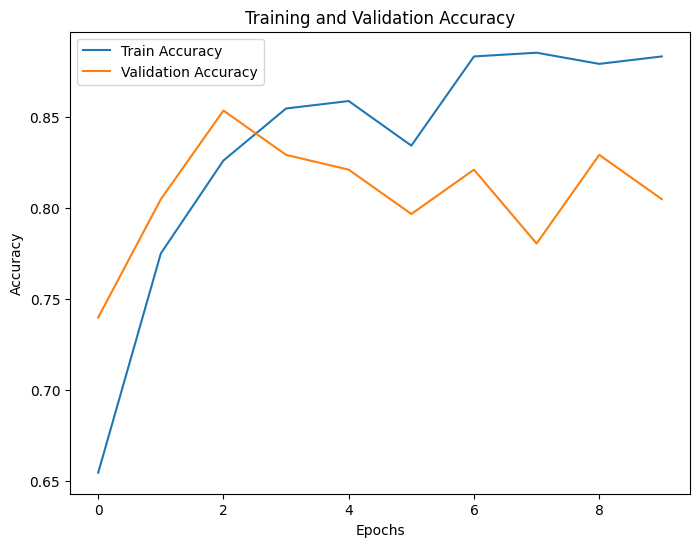

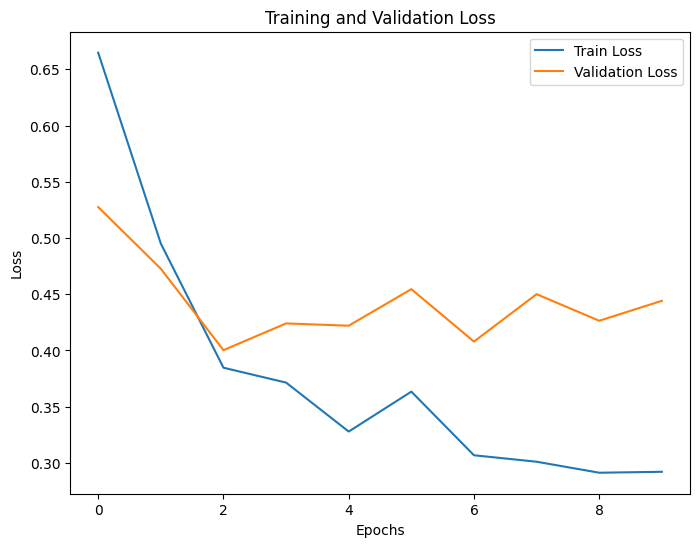

In [ ]:
def plot_training_accuracy(history):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 6))
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

def plot_training_loss(history):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 6))
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()


 # Generate predictions
y_pred_probs = model.predict(X_test).flatten()  # Flatten to 1D array
y_pred = (y_pred_probs > 0.5).astype(int)       # Convert probabilities to binary predictions
# Training and Validation Accuracy
plot_training_accuracy(history)
# Training and Validation Loss
plot_training_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.66      0.78        68
         1.0       0.70      0.96      0.81        55

    accuracy                           0.80       123
   macro avg       0.83      0.81      0.80       123
weighted avg       0.84      0.80      0.79       123



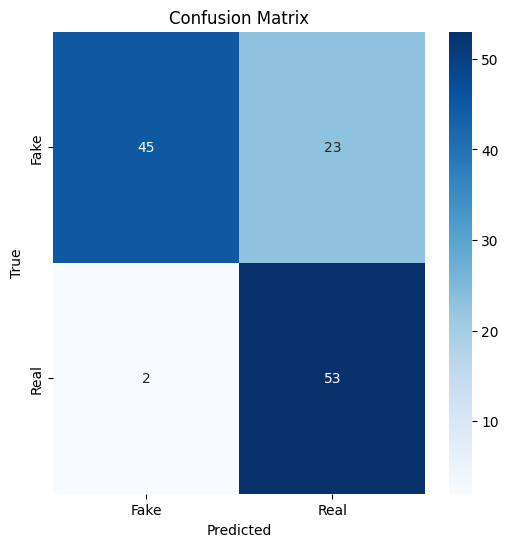

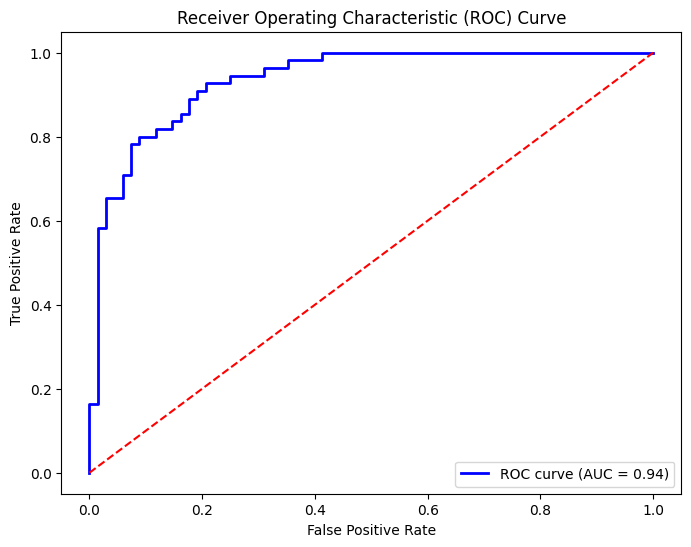

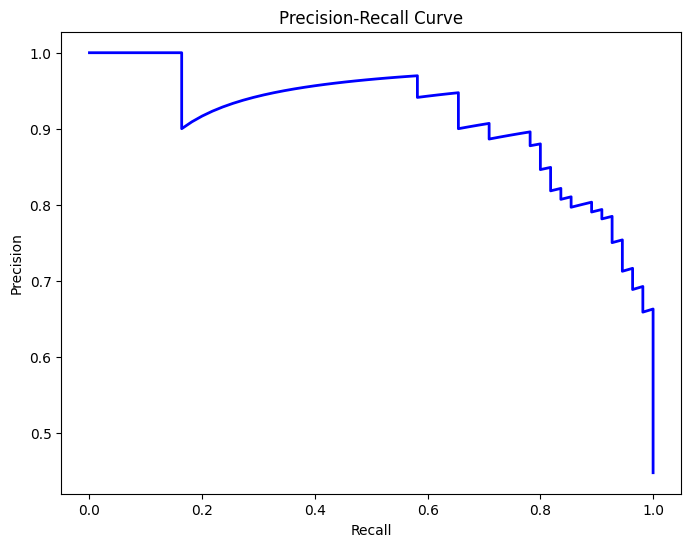

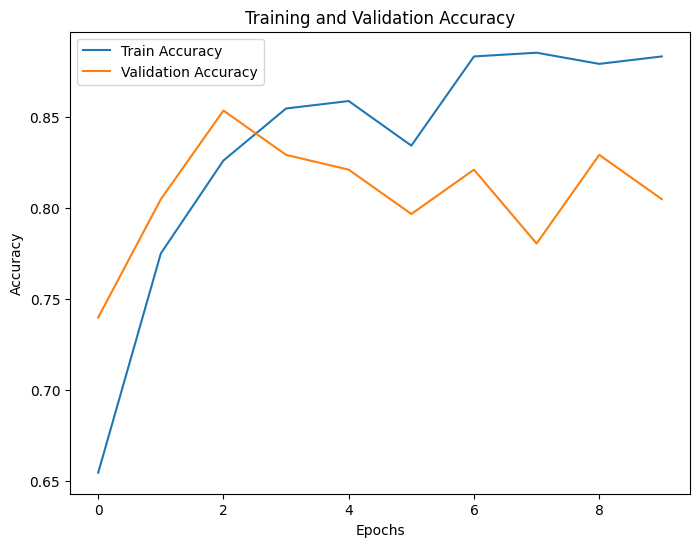

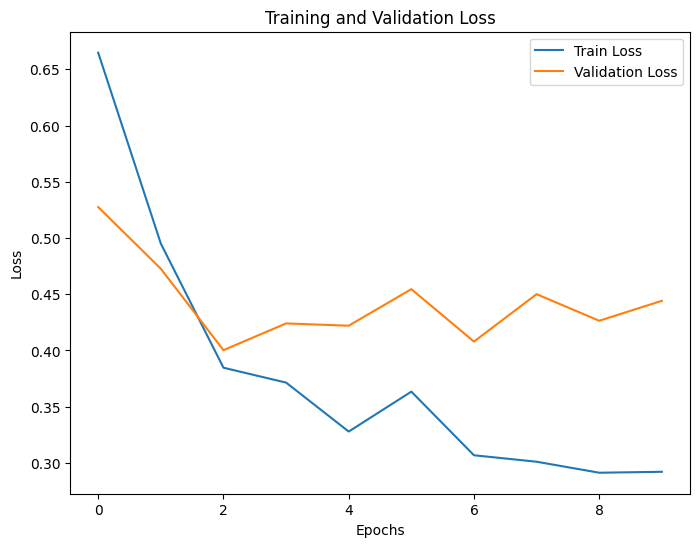

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes=["Fake", "Real"]):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="red", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_probs):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color="blue", lw=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.show()

# Function to plot training and validation accuracy/loss
def plot_training_history(history):
    # Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

    # Loss
    plt.figure(figsize=(8, 6))
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

# Generate evaluation metrics and plots
def evaluate_model(y_true, y_probs, y_pred, history):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    plot_confusion_matrix(y_true, y_pred)

    # ROC Curve
    plot_roc_curve(y_true, y_probs)

    # Precision-Recall Curve
    plot_precision_recall_curve(y_true, y_probs)

    # Training and Validation History
    plot_training_history(history)

# Example usage
# Assuming `y_test`, `y_pred_probs`, and `history` are available
# `y_test` is the ground truth labels for the test set
# `y_pred_probs` is the predicted probabilities for the test set
# `history` is the training history returned from model.fit()

# Generate predictions
y_pred_probs = model.predict(X_test).flatten()  # Flatten to 1D array
y_pred = (y_pred_probs > 0.5).astype(int)       # Convert probabilities to binary predictions

# Evaluate the model
evaluate_model(y_test, y_pred_probs, y_pred, history)


Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: Fake (Confidence: 0.99)


<ipython-input-41-54d75f531cd1>:45: RuntimeWarning: invalid value encountered in divide
  cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize
<ipython-input-41-54d75f531cd1>:47: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)


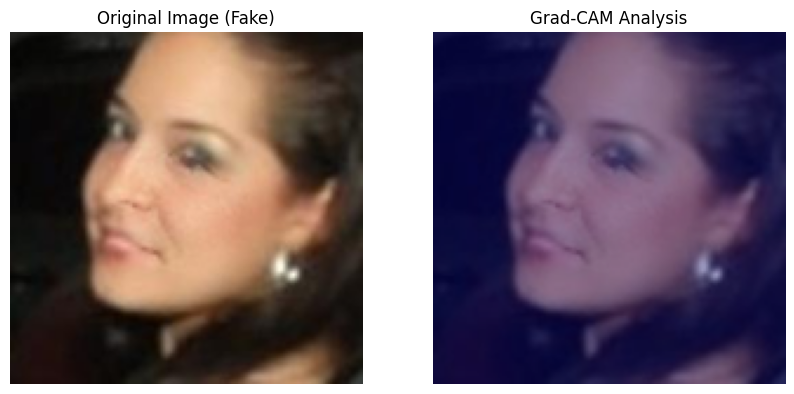

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
import tensorflow as tf

# Parameters
img_size = 150

# Load the pre-trained model
model = load_model("advanced_deepfake_detection_model.h5")
print("Model loaded successfully.")

# Function to preprocess a single image
def preprocess_image(image_path):
    """
    Preprocesses an image for model prediction.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Invalid or unreadable image file: {image_path}")
    img_resized = cv2.resize(img, (img_size, img_size))
    img_normalized = img_resized / 255.0
    return img_resized, np.expand_dims(img_normalized, axis=0)

# Grad-CAM visualization function
def visualize_gradcam(image, model, layer_name='block14_sepconv2_act'):
    """
    Generates Grad-CAM visualization for the given image.
    """
    img_resized = cv2.resize(image, (img_size, img_size))
    img_input = np.expand_dims(img_resized / 255.0, axis=0)
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_input)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.sum(weights * conv_outputs[0], axis=-1)
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (img_size, img_size))
    cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    img_resized_uint8 = np.uint8(img_resized)
    superimposed = cv2.addWeighted(img_resized_uint8, 0.6, heatmap, 0.4, 0)

    return superimposed

# Demo function for real-time image detection
def demo_image_detection(image_path):
    """
    Predicts if an image is real or fake and visualizes the Grad-CAM analysis.
    """
    try:
        # Preprocess image
        original_img, preprocessed_img = preprocess_image(image_path)

        # Predict real or fake
        prediction = model.predict(preprocessed_img)[0][0]
        label = "Real" if prediction > 0.5 else "Fake"
        confidence = prediction if label == "Real" else 1 - prediction
        print(f"Prediction: {label} (Confidence: {confidence:.2f})")

        # Grad-CAM visualization
        gradcam_image = visualize_gradcam(original_img, model)

        # Display results
        plt.figure(figsize=(10, 5))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Image ({label})")
        plt.axis('off')

        # Grad-CAM Visualization
        plt.subplot(1, 2, 2)
        plt.imshow(gradcam_image[..., ::-1])
        plt.title("Grad-CAM Analysis")
        plt.axis('off')

        plt.show()
    except Exception as e:
        print(f"Error: {e}")

# Debugging and running the demo
demo_image_path = "/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/fake_10980.jpg"  # Replace with your image path

# Check if the file exists and run the detection
if os.path.exists(demo_image_path):
    try:
        demo_image_detection(demo_image_path)
    except ValueError as ve:
        print(ve)
else:
    print(f"File not found: {demo_image_path}")
